# Model is weighing clean sheet potentials too highly, biasing away from forwards

In [29]:
import pandas as pd
import numpy as np
import pulp
from datetime import date

In [30]:
def calculate_player_points(position, clean_sheet_proba, assists, goals):
    total_points = 0
    total_points += assists * 3
    
    if position <=2:
        total_points += goals * 6
        total_points += clean_sheet_proba * 4
    
    if position == 3:
        total_points += goals * 5
        total_points += clean_sheet_proba * 1
    
    if position == 4:
        total_points += goals * 4
        
    return total_points

In [31]:
df = pd.read_pickle('../data/simulated_player_outcomes.pkl')

In [32]:
# Fill na values for the goal keepers, who don't have goals/assist stats
df.loc[df.pos == 1] = df[df.pos == 1].fillna(0)

In [33]:
df['x_points'] = df.apply(lambda x: calculate_player_points(x.pos, x.clean_sheet_proba, x.mean_assists, x.mean_goals), axis=1)

In [34]:
df['gw_rank'] = df['x_points'].rank(ascending=False)

In [35]:
# don't inlcude any backup goalkeeprs for selection

backup_gks = list(df[(df.pos == 1) & (df.minutes == 0)].name)
df = df[~df.name.isin(backup_gks)]

Build Optimizer & Pick Team

In [36]:
def select_players(expected_scores, prices, positions, clubs, total_budget=100, sub_factor=0.2):
    num_players = len(expected_scores)
    model = pulp.LpProblem("Constrained value maximisation", pulp.LpMaximize)
    decisions = [
        pulp.LpVariable("x{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    captain_decisions = [
        pulp.LpVariable("y{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    sub_decisions = [
        pulp.LpVariable("z{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]


    # objective function:
    model += sum((captain_decisions[i] + decisions[i] + sub_decisions[i]*sub_factor) * expected_scores[i]
                 for i in range(num_players)), "Objective"

    # cost constraint
    model += sum((decisions[i] + sub_decisions[i]) * prices[i] for i in range(num_players)) <= total_budget  # total cost

    # position constraints
    # 1 starting goalkeeper
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 1) == 1
    # 2 total goalkeepers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 1) == 2

    # 3-5 starting defenders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) <= 5
    # 5 total defenders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 2) == 5

    # 3-5 starting midfielders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) <= 5
    # 5 total midfielders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 3) == 5

    # 1-3 starting attackers
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) >= 1
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) <= 3
    # 3 total attackers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 4) == 3

    # club constraint
    for club_id in np.unique(clubs):
        model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if clubs[i] == club_id) <= 3  # max 3 players

    model += sum(decisions) == 11  # total team size
    model += sum(captain_decisions) == 1  # 1 captain
    
    for i in range(num_players):  
        model += (decisions[i] - captain_decisions[i]) >= 0  # captain must also be on team
        model += (decisions[i] + sub_decisions[i]) <= 1  # subs must not be on team

    model.solve(pulp.PULP_CBC_CMD(logPath=r'solver_output.lp'))
    print("Total expected score = {}".format(model.objective.value()))

    return decisions, captain_decisions, sub_decisions

In [37]:
def pick_best_team(df):
    """ Picks the best fieldable team from a dataframe of expected points.
    
    Expects columns: team, pos, now_cost, x_points
    """
    expected_scores = df.x_points.values
    prices = df.now_cost.values / 10
    positions = df.pos.values
    teams = df.team.values
    
    decisions, captain_decisions, sub_decisions = select_players(expected_scores, prices, positions, teams)
    
    captain = df[[x.value() == 1 for x in captain_decisions]]['name'].to_string(index=False)
    print(f'Captain: {captain}')
    
    selection_df = df.copy()[['name', 'team', 'pos', 'now_cost', 'minutes', 'match_date', 'mean_assists', 'mean_goals', 'mean_goals_against', 'x_points', 'gw_rank']]
    
    first_index = [x.value() == 1 for x in decisions]
    first = selection_df[first_index].sort_values(['pos', 'gw_rank'])
    first['selection'] = 'start'
    
    subs_index = [x.value() == 1 for x in sub_decisions]
    subs = selection_df[subs_index].sort_values(['pos', 'gw_rank'])
    subs['selection'] = 'sub'
    
    result = pd.concat([first, subs])
    display(result)
    return result

In [38]:
selected_team = pick_best_team(df)

/Users/andrew.peters/.pyenv/versions/3.8.13/envs/fpl/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/Users/andrew.peters/.pyenv/versions/3.8.13/envs/fpl/lib/python3.8/site-packages/pulp/apis/coin_api.py:186: UserWarning: `logPath` argument replaces `msg=1`. The output will be redirected to the log file.
  warnings.warn(


Total expected score = 26.221474483007594
Captain: Joao Cancelo


,name,team,pos,now_cost,minutes,match_date,mean_assists,mean_goals,mean_goals_against,x_points,gw_rank,selection
457,Lukasz Fabianski,West Ham,1,50,1693,2022-01-21,0.0000,0.0000,1.0393,1.563101,70.5,start
321,Joao Cancelo,Man City,2,71,1273,2022-01-22,0.1501,0.0640,0.8166,2.825305,1.0,start
332,Rico Lewis,Man City,2,39,360,2022-01-22,0.0884,0.0626,0.8166,2.631805,2.0,start
333,Sergio Gomez,Man City,2,45,106,2022-01-22,0.0908,0.0561,0.8166,2.600005,3.0,start
440,Aaron Cresswell,West Ham,2,48,1533,2022-01-21,0.1167,0.0341,1.0393,2.117801,12.0,start
365,Matt Ritchie,Newcastle,2,42,3,2022-01-21,0.1029,0.0497,1.1134,2.065779,14.0,start
4,Martin Odegaard,Arsenal,3,69,1522,2022-01-22,0.1974,0.1867,1.2930,1.821423,34.0,start
12,Gabriel Martinelli Silva,Arsenal,3,67,1609,2022-01-22,0.1502,0.2007,1.2930,1.749823,44.0,start
9,Bukayo Saka,Arsenal,3,82,1624,2022-01-22,0.1790,0.1825,1.2930,1.745223,45.0,start
265,Mohamed Salah,Liverpool,3,127,1687,2022-01-21,0.1129,0.2143,1.2780,1.706472,52.0,start


In [39]:
date_path = date.today().strftime('%Y_%m_%d')
path = f'../data/historical/{date_path}'

# save to historical folder as well
selected_team.to_pickle(f'{path}/selected_team.pkl')

In [40]:
%%capture

team_selections_trials = pd.DataFrame(columns=list(selected_team))
for run in range(10):
    
    already_selected = team_selections_trials.name
    eligible_players = df[~df.name.isin(already_selected)]
    
    team = pick_best_team(eligible_players)
    team['run'] = run
    
    team_selections_trials = pd.concat([team_selections_trials, team])

In [41]:
date_path = date.today().strftime('%Y_%m_%d')
path = f'../data/historical/{date_path}'

# save to historical folder as well
team_selections_trials.to_pickle(f'{path}/team_selections_trials.pkl')

In [42]:
team_selections_trials.head(30)

,name,team,pos,now_cost,minutes,match_date,mean_assists,mean_goals,mean_goals_against,x_points,gw_rank,selection,run
457,Lukasz Fabianski,West Ham,1,50,1693,2022-01-21,0.0000,0.0000,1.0393,1.563101,70.5,start,0.0
321,Joao Cancelo,Man City,2,71,1273,2022-01-22,0.1501,0.0640,0.8166,2.825305,1.0,start,0.0
332,Rico Lewis,Man City,2,39,360,2022-01-22,0.0884,0.0626,0.8166,2.631805,2.0,start,0.0
333,Sergio Gomez,Man City,2,45,106,2022-01-22,0.0908,0.0561,0.8166,2.600005,3.0,start,0.0
440,Aaron Cresswell,West Ham,2,48,1533,2022-01-21,0.1167,0.0341,1.0393,2.117801,12.0,start,0.0
365,Matt Ritchie,Newcastle,2,42,3,2022-01-21,0.1029,0.0497,1.1134,2.065779,14.0,start,0.0
4,Martin Odegaard,Arsenal,3,69,1522,2022-01-22,0.1974,0.1867,1.2930,1.821423,34.0,start,0.0
12,Gabriel Martinelli Silva,Arsenal,3,67,1609,2022-01-22,0.1502,0.2007,1.2930,1.749823,44.0,start,0.0
9,Bukayo Saka,Arsenal,3,82,1624,2022-01-22,0.1790,0.1825,1.2930,1.745223,45.0,start,0.0
265,Mohamed Salah,Liverpool,3,127,1687,2022-01-21,0.1129,0.2143,1.2780,1.706472,52.0,start,0.0


In [43]:
team_selections_trials.groupby('name')['run'].count().reset_index().sort_values('run', ascending=False)

,name,run
1,Aaron Ramsdale,2
53,Hugo Lloris,2
93,Mark Travers,1
95,Matt Doherty,1
96,Matt Ritchie,1
...,...,...
49,Granit Xhaka,1
50,Harry Kane,1
51,Harry Toffolo,1
52,Harry Wilson,1


In [44]:
team_selections_trials[team_selections_trials.run == 1]

,name,team,pos,now_cost,minutes,match_date,mean_assists,mean_goals,mean_goals_against,x_points,gw_rank,selection,run
388,Nick Pope,Newcastle,1,55,1800,2022-01-21,0.0000,0.0000,1.1134,1.458879,99.5,start,1.0
318,John Stones,Man City,2,54,1180,2022-01-22,0.0653,0.0545,0.8166,2.513905,4.0,start,1.0
454,Emerson Palmieri dos Santos,West Ham,2,40,364,2022-01-21,0.0556,0.0536,1.0393,2.051501,15.0,start,1.0
367,Kieran Trippier,Newcastle,2,61,1774,2022-01-21,0.1105,0.0425,1.1134,2.045379,16.0,start,1.0
455,Thilo Kehrer,West Ham,2,44,1350,2022-01-21,0.0885,0.0314,1.0393,2.017001,17.0,start,1.0
444,Vladimir Coufal,West Ham,2,41,1110,2022-01-21,0.0928,0.0290,1.0393,2.015501,18.0,start,1.0
317,Kevin De Bruyne,Man City,3,124,1566,2022-01-22,0.2678,0.1796,0.8166,2.199151,10.0,start,1.0
8,Emile Smith Rowe,Arsenal,3,56,48,2022-01-22,0.1557,0.1733,1.2930,1.629323,62.0,start,1.0
239,Rodrigo Moreno,Leeds,3,64,1296,2022-01-22,0.1109,0.2005,1.5332,1.561868,72.0,start,1.0
279,Cody Gakpo,Liverpool,3,78,171,2022-01-21,0.1172,0.1777,1.2780,1.536372,83.0,start,1.0


In [45]:
team_selections_trials[team_selections_trials.run == 1]

,name,team,pos,now_cost,minutes,match_date,mean_assists,mean_goals,mean_goals_against,x_points,gw_rank,selection,run
388,Nick Pope,Newcastle,1,55,1800,2022-01-21,0.0000,0.0000,1.1134,1.458879,99.5,start,1.0
318,John Stones,Man City,2,54,1180,2022-01-22,0.0653,0.0545,0.8166,2.513905,4.0,start,1.0
454,Emerson Palmieri dos Santos,West Ham,2,40,364,2022-01-21,0.0556,0.0536,1.0393,2.051501,15.0,start,1.0
367,Kieran Trippier,Newcastle,2,61,1774,2022-01-21,0.1105,0.0425,1.1134,2.045379,16.0,start,1.0
455,Thilo Kehrer,West Ham,2,44,1350,2022-01-21,0.0885,0.0314,1.0393,2.017001,17.0,start,1.0
444,Vladimir Coufal,West Ham,2,41,1110,2022-01-21,0.0928,0.0290,1.0393,2.015501,18.0,start,1.0
317,Kevin De Bruyne,Man City,3,124,1566,2022-01-22,0.2678,0.1796,0.8166,2.199151,10.0,start,1.0
8,Emile Smith Rowe,Arsenal,3,56,48,2022-01-22,0.1557,0.1733,1.2930,1.629323,62.0,start,1.0
239,Rodrigo Moreno,Leeds,3,64,1296,2022-01-22,0.1109,0.2005,1.5332,1.561868,72.0,start,1.0
279,Cody Gakpo,Liverpool,3,78,171,2022-01-21,0.1172,0.1777,1.2780,1.536372,83.0,start,1.0


In [46]:
df.sort_values('gw_rank').head(20)

,name,web_name,team,pos,now_cost,minutes,match_date,proba_assist,proba_goal,assist_share,goal_share,mean_assists,mean_goals,mean_goals_against,clean_sheet_proba,x_points,gw_rank
321,Joao Cancelo,Cancelo,Man City,2,71,1273,2022-01-22,0.284698,0.128205,0.058718,0.028206,0.1501,0.0640,0.8166,0.497751,2.825305,1.0
332,Rico Lewis,Lewis,Man City,2,39,360,2022-01-22,0.166667,0.112835,0.034374,0.024825,0.0884,0.0626,0.8166,0.497751,2.631805,2.0
333,Sergio Gomez,Sergio Gómez,Man City,2,45,106,2022-01-22,0.166667,0.109739,0.034374,0.024144,0.0908,0.0561,0.8166,0.497751,2.600005,3.0
318,John Stones,Stones,Man City,2,54,1180,2022-01-22,0.135135,0.105960,0.027871,0.023312,0.0653,0.0545,0.8166,0.497751,2.513905,4.0
323,Aymeric Laporte,Laporte,Man City,2,57,375,2022-01-22,0.100000,0.116110,0.020625,0.025545,0.0500,0.0614,0.8166,0.497751,2.509405,5.0
322,Nathan Ake,Aké,Man City,2,50,1065,2022-01-22,0.100000,0.108844,0.020625,0.023946,0.0549,0.0566,0.8166,0.497751,2.495305,6.0
315,Kyle Walker,Walker,Man City,2,48,702,2022-01-22,0.167832,0.071429,0.034615,0.015715,0.0794,0.0412,0.8166,0.497751,2.476405,7.0
334,Manuel Akanji,Akanji,Man City,2,50,1196,2022-01-22,0.076923,0.097800,0.015865,0.021517,0.0394,0.0555,0.8166,0.497751,2.442205,8.5
325,Ruben Gato Alves Dias,Dias,Man City,2,59,872,2022-01-22,0.083333,0.095890,0.017187,0.021097,0.0432,0.0536,0.8166,0.497751,2.442205,8.5
317,Kevin De Bruyne,De Bruyne,Man City,3,124,1566,2022-01-22,0.520607,0.330579,0.107373,0.072730,0.2678,0.1796,0.8166,0.497751,2.199151,10.0


In [47]:
df[df.pos == 4].sort_values('gw_rank').head(30)

,name,web_name,team,pos,now_cost,minutes,match_date,proba_assist,proba_goal,assist_share,goal_share,mean_assists,mean_goals,mean_goals_against,clean_sheet_proba,x_points,gw_rank
329,Erling Haaland,Haaland,Man City,4,122,1545,2022-01-22,0.272727,0.715337,0.056249,0.157380,0.1418,0.3871,0.8166,0.497751,1.9738,25.0
330,Julian Alvarez,Álvarez,Man City,4,60,476,2022-01-22,0.283688,0.512516,0.058509,0.112758,0.1401,0.2830,0.8166,0.497751,1.5523,78.0
289,Harry Kane,Kane,Tottenham,4,117,1876,2022-01-23,0.248447,0.495897,0.062106,0.155613,0.1131,0.2727,1.4384,0.254633,1.4301,109.0
188,Aleksandar Mitrovic,Mitrović,Fulham,4,70,1463,2022-01-23,0.181818,0.465929,0.055061,0.184338,0.0826,0.2696,1.7537,0.186308,1.3262,127.0
67,Ivan Toney,Toney,Brentford,4,77,1611,2022-01-22,0.233918,0.444198,0.073970,0.153975,0.1115,0.2405,1.6921,0.197110,1.2965,133.0
28,Ollie Watkins,Watkins,Aston Villa,4,71,1538,2022-01-21,0.224719,0.315582,0.095232,0.152777,0.1274,0.2143,1.4139,0.266869,1.2394,149.0
7,Eddie Nketiah,Nketiah,Arsenal,4,67,591,2022-01-22,0.205128,0.349574,0.067346,0.120622,0.1214,0.2112,1.2930,0.295723,1.2090,158.0
438,Danny Ings,Ings,West Ham,4,64,831,2022-01-21,0.250000,0.375704,0.071351,0.114367,0.1145,0.1913,1.0393,0.390775,1.1087,218.0
275,Darwin Nunez Ribeiro,Darwin,Liverpool,4,88,895,2022-01-21,0.209974,0.390054,0.050993,0.117108,0.0918,0.2050,1.2780,0.296272,1.0954,222.0
385,Alexander Isak,Isak,Newcastle,4,66,283,2022-01-21,0.266667,0.400300,0.066773,0.116337,0.1096,0.1903,1.1134,0.364720,1.0900,226.0


In [48]:
df[df.name == 'Andreas Hoelgebaum Pereira']

,name,web_name,team,pos,now_cost,minutes,match_date,proba_assist,proba_goal,assist_share,goal_share,mean_assists,mean_goals,mean_goals_against,clean_sheet_proba,x_points,gw_rank
194,Andreas Hoelgebaum Pereira,Andreas,Fulham,3,45,1728,2022-01-23,0.254777,0.16129,0.077156,0.063812,0.1131,0.0906,1.7537,0.186308,0.978608,300.0


In [49]:
df[df.team == 'Man Utd'].sort_values('gw_rank')

,name,web_name,team,pos,now_cost,minutes,match_date,proba_assist,proba_goal,assist_share,goal_share,mean_assists,mean_goals,mean_goals_against,clean_sheet_proba,x_points,gw_rank
344,Marcus Rashford,Rashford,Man Utd,3,72,1616,2022-01-22,0.205128,0.296022,0.073107,0.123898,0.0983,0.1604,1.8665,0.167059,1.263959,143.0
357,Antony Matheus dos Santos,Antony,Man Utd,3,73,830,2022-01-22,0.206897,0.222694,0.073738,0.093207,0.1013,0.1241,1.8665,0.167059,1.091459,224.0
343,Bruno Borges Fernandes,Fernandes,Man Utd,3,99,1709,2022-01-22,0.273038,0.208062,0.097310,0.087083,0.1249,0.1096,1.8665,0.167059,1.089759,227.0
348,Diogo Dalot Teixeira,Dalot,Man Utd,2,47,1186,2022-01-22,0.142857,0.057971,0.050914,0.024263,0.0651,0.0365,1.8665,0.167059,1.082535,231.0
342,Luke Shaw,Shaw,Man Utd,2,53,1323,2022-01-22,0.181818,0.045714,0.064800,0.019133,0.0842,0.0264,1.8665,0.167059,1.079235,234.0
356,Alejandro Garnacho,Garnacho,Man Utd,3,42,237,2022-01-22,0.222222,0.195122,0.079200,0.081667,0.1070,0.1096,1.8665,0.167059,1.036059,266.0
353,Tyrell Malacia,Malacia,Man Utd,2,42,836,2022-01-22,0.125000,0.043478,0.044550,0.018198,0.0602,0.0275,1.8665,0.167059,1.013835,283.0
340,Harry Maguire,Maguire,Man Utd,2,47,385,2022-01-22,0.050000,0.073394,0.017820,0.030719,0.0214,0.0441,1.8665,0.167059,0.997035,292.0
347,Aaron Wan-Bissaka,Wan-Bissaka,Man Utd,2,43,522,2022-01-22,0.100000,0.036697,0.035640,0.015359,0.0512,0.0198,1.8665,0.167059,0.940635,316.0
349,Brandon Williams,B.Williams,Man Utd,2,38,0,2022-01-22,0.090909,0.045802,0.032400,0.019170,0.0411,0.0221,1.8665,0.167059,0.924135,321.0


In [50]:
df.team.unique()

array(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton',
       'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Leicester',
       'Leeds', 'Liverpool', 'Tottenham', 'Man City', 'Man Utd',
       'Newcastle', 'Nottm Forest', 'Southampton', 'West Ham', 'Wolves'],
      dtype=object)

<AxesSubplot:>

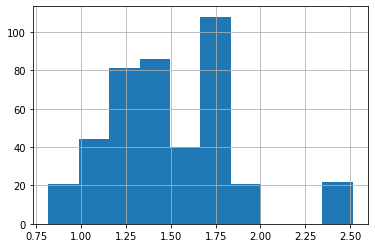

In [51]:
df.mean_goals_against.hist()